# Age Conversion with CycleGAN

For a more detailed breakdown of the code, check out the full tutorial on the [Paperspace Blog](https://blog.paperspace.com/use-cyclegan-age-conversion-keras-python/).

Install dependencies

In [ ]:
# !pip install requests
# !apt update && apt install -y libsm6 libxext6 libxrender-dev
# !pip install imageio
# !pip install scikit-image
# !pip install --upgrade pip setuptools wheel
# !pip install opencv-python
# !pip install numpy==1.16.4
# !pip install keras==1.2

Download data

In [2]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

if __name__ == "__main__":
    file_id = 'TAKE ID FROM SHAREABLE LINK'
    destination = 'DESTINATION FILE ON YOUR DISK'
    download_file_from_google_drive("0BxYys69jI14kYVM3aVhKS1VhRUk", "UTKFace.tar.gz")

Arrange data

In [3]:
!gunzip UTKFace.tar.gz
!tar -xf UTKFace.tar

In [4]:
!mkdir data
!mkdir data/trainA data/trainB 

In [5]:
import os, shutil
images = os.listdir("UTKFace")
for f in images:
  try:
    val = f.split("_")
    age = int(val[0])
    if(age >=20 and age<=30):
      shutil.copy("UTKFace/"+f, "data/trainA")
    if(age >=50 and age<=60):
      shutil.copy("UTKFace/"+f, "data/trainB")   
  except:
    print(f)

Dataloader and preprocessing for input images

In [22]:
import scipy
from glob import glob
import numpy as np
from skimage.transform import resize
import imageio

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        path = glob('./%s/%s%s/*' % (self.dataset_name, "train", domain))
        #data_type = "train%s" % domain if not is_testing else "test%s" % domain
        
        
        batch_images = np.random.choice(path, size=batch_size)
        imgs = []
        print(domain, batch_images)
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        path_A = glob('./%s/%sA/*' % (self.dataset_name, "train"))
        path_B = glob('./%s/%sB/*' % (self.dataset_name, "train"))
        print(len(path_A), len(path_B))
        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)      
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):            
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = resize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]
      
    def get_img(self, img):
        img = resize(img, self.img_res)
        img = img/127.5 - 1.
        return img
      
    def revert_img(self, img, new_res):
      img = resize(img, new_res)
      img = (img)*0.5 + 0.5
      img = img*255
      img = img.astype(np.float32)
      return img 

    def imread(self, path):
        return imageio.imread(path, as_gray=False, pilmode="RGB").astype(np.float)
      
def revert_img(img, new_res):
  img = (img)*0.5 + 0.5
  img = img*255
  img = resize(img, new_res)
  img = img.astype(np.float32)
  return img

## CycleGAN code

Follow the tricks mentioned in [the article](https://blog.paperspace.com/use-cyclegan-age-conversion-keras-python/).

In [ ]:
from __future__ import print_function, division
import scipy, os
import scipy.misc

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu 
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import keras
import shutil, os, random
from keras.models import load_model

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)  

        # Configure data loader
        self.dataset_name = 'data'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        # Loss weights
        self.lambda_cycle = 0.1                   # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)
        pdir = "/content/drive/My Drive/keras_combined_gan/"
        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_A.compile(loss='mse',
          optimizer=optimizer,
          metrics=['accuracy'])
                
        
        self.d_B = self.build_discriminator()
        self.d_B.compile(loss='mse',
          optimizer=optimizer,
          metrics=['accuracy'])
        

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False        

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)    

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                                outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                  'mae', 'mae'],
                            loss_weights=[  1, 1,
                                          self.lambda_cycle, self.lambda_cycle,
                                          self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """Resnet Generator"""

        def conv2d(layer_input, filters=16, strides=1, name=None, f_size=4):
            d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', name=name)(layer_input)
            d = InstanceNormalization(name=name+"_bn")(d)
            d = Activation('relu')(d)
            return d
          
        def residual(layer_input, filters=16, strides=1, name=None, f_size=3):
            d = conv2d(layer_input, filters=filters, strides=strides, name=name, f_size=f_size)
            d = Conv2D(filters, kernel_size=f_size, strides=strides, padding='same', name=name+"_2")(d)
            d = InstanceNormalization(name=name+"_bn2")(d)
            d = keras.layers.add([d, layer_input])
            return d

        def conv2d_transpose(layer_input, filters=16, strides=1, name=None, f_size=4):
            u = Conv2DTranspose(filters, strides=strides, name=name, kernel_size=f_size, padding='same')(layer_input)
            u = InstanceNormalization(name=name+"_bn")(u)
            u = Activation('relu')(u)
            return u

        # Image input
        c0 = Input(shape=self.img_shape)
        c1 = conv2d(c0, filters=self.gf, strides=1, name="g_e1", f_size=7)
        c2 = conv2d(c1, filters=self.gf*2, strides=2, name="g_e2", f_size=3)
        c3 = conv2d(c2, filters=self.gf*4, strides=2, name="g_e3", f_size=3)
        
        r1 = residual(c3, filters=self.gf*4, name='g_r1')
        r2 = residual(r1, self.gf*4, name='g_r2')
        r3 = residual(r2, self.gf*4, name='g_r3')
        r4 = residual(r3, self.gf*4, name='g_r4')
        r5 = residual(r4, self.gf*4, name='g_r5')
        r6 = residual(r5, self.gf*4, name='g_r6')
        r7 = residual(r6, self.gf*4, name='g_r7')
        r8 = residual(r7, self.gf*4, name='g_r8')
        r9 = residual(r8, self.gf*4, name='g_r9')
        
        d1 = conv2d_transpose(r9, filters=self.gf*2, f_size=3, strides=2, name='g_d1_dc')
        d2 = conv2d_transpose(d1, filters=self.gf, f_size=3, strides=2, name='g_d2_dc')
        
        output_img = Conv2D(self.channels, kernel_size=7, strides=1, padding='same', activation='tanh')(d2)

        return Model(inputs=[c0], outputs=[output_img])

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain     
                fake_B = self.g_AB.predict([imgs_A])
                fake_A = self.g_BA.predict([imgs_B])

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)               
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)                
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)                
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)
                
                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])                                          
                
                elapsed_time = datetime.datetime.now() - start_time
                if batch_i%50==0:
                  # Plot the progress
                  print ("[Age Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f]  time: %s " \
                                                                          % ( epoch, epochs,
                                                                              batch_i, self.data_loader.n_batches,
                                                                              d_loss[0], 100*d_loss[1],
                                                                              g_loss[0],
                                                                              np.mean(g_loss[1:3]),
                                                                              np.mean(g_loss[3:5]),
                                                                              np.mean(g_loss[5:6]),
                                                                              elapsed_time))  
                  
                                                                              
                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)    
                  
            
    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3
        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=False)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=False)

        # Translate images to the other domain
        fake_B = self.g_AB.predict([imgs_A])
        fake_A = self.g_BA.predict([imgs_B])
        # Translate back to original domain
        reconstr_A = self.g_BA.predict([fake_B])
        reconstr_B = self.g_AB.predict([fake_A])

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()
        
    def run_20_to_50(self, image):
        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)        
        fake_B = self.g_AB.predict(imgs_A)

gan = CycleGAN()
gan.train(epochs=5, batch_size=2, sample_interval=10)

## Face Detection

In [ ]:
#!wget https://github.com/spmallick/learnopencv/raw/master/FaceDetectionComparison/models/opencv_face_detector_uint8.pb
#!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/opencv_face_detector.pbtxt

In [ ]:
#!wget https://statics.sportskeeda.com/editor/2018/09/4c606-1536825356-800.jpg 
#!mv 4c606-1536825356-800.jpg big3.jpg

In [ ]:
import cv2
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
def detectFaceOpenCVDnn(net, frame):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (frameHeight, frameWidth), [104, 117, 123], False, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            if not(x1<30 or y1<30 or x2>frameWidth-30 or y2>frameHeight-30):
              y1, y2 = y1-20, y2+20
              x1, x2 = x1-20, x2+20
            else:
              continue
            crop_img = frameOpencvDnn[y1:y2, x1:x2]
            crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB).astype("float32")
            cv2.imwrite("cropped"+str(i)+".jpg", crop_img)
            inp = np.array([gan.data_loader.get_img(crop_img)])
            old_img = gan.g_AB.predict([inp])
            new_img = revert_img(old_img[0], (y2-y1, x2-x1))
            new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR).astype("float32")
            frameOpencvDnn[y1:y2, x1:x2] = new_img
            imageio.imwrite("old"+str(i)+".jpg", new_img)
    return frameOpencvDnn, bboxes
  
conf_threshold = 0.8
modelFile = "opencv_face_detector_uint8.pb"
configFile = "opencv_face_detector.pbtxt"
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
frame = cv2.imread("big3.jpg")
outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,frame) #,0
cv2.imwrite("big3_old.jpg", outOpencvDnn)
#outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,frame) #,1
#cv2.imwrite("big3_black.jpg", outOpencvDnn)

In [20]:
im = cv2.imread('big3_old.jpg')

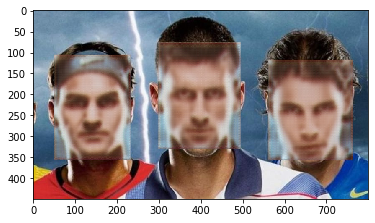

In [21]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))